In [1]:
%load_ext autoreload
%autoreload 2

import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "ExplanationPairSentencesTasks":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# Data Modules
from src.data_module.hatexplain import CLSTokenHateXPlainDM
from src.data_module.esnli import CLSTokenESNLIDM
from src.data_module.yelp_hat import CLSTokenYelpHat50DM, CLSTokenYelpHatDM

# Model
from pur_attention_key_reg import AttitModel

# Utils
from notebooks.attention_based.utils.count_class import search_rep, compute_cos, process_data_frame

# External librairies
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm
import pandas as pd

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

>> current directory : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks
>> cache path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache
>> model path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\models
>> dataset path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\logs
>> device : cuda


# HateXplain

In [2]:
%%capture
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=900
                 )

dm = CLSTokenHateXPlainDM(**dm_kwargs)
dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader()

model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="hatexplain",
        num_class=dm.num_class,
        opt="adam"
)

df_array = []

for l in range(5) :

    # update the args for the model
    model_args["num_layers"] = l+1
    ckp = os.path.join(log_path, "PurAttention", f"run=0_hatexplain_l=0{l+1}_h=1_adam", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttention", f"run=0_hatexplain_l=0{l+1}_h=1_adam", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    # the dictionnaries for the dataframes
    key_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    val_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    emb_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    class_id = np.array([])

    with torch.no_grad():

        model = model.to(DEVICE)

        # get the representative of the classes
        # for the 1 layer model : we proceed the mean over the different
        class_rep_res = search_rep(model, dm, mean_calc= l==0)

        pbar = tqdm(enumerate(test_dataloader), total = int(dm.n_data/32))

        for id_batch, batch in pbar:

            ids = batch["token_ids"].to(DEVICE)
            class_id = np.concatenate((class_id, batch["y_true"].to(DEVICE).cpu().numpy()))
            padding_mask = batch["padding_mask"].bool().to(DEVICE)

            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            for c in range(dm.num_class):
                # we'll compute the similarity with the class c
                if l != 0:
                    curr_k = k[l][:, 0, :] # the keys
                    curr_v = v[l][:, 0, :] # the values
                    curr_emb = emb[l+1][:, 0, :] # the embeddings
                else:
                    curr_k = k[l][:, 1:, :].mean(dim=1) # the keys
                    curr_v = v[l][:, 1:, :].mean(dim=1) # the values
                    curr_emb = emb[l+1][:, 1:, :].mean(dim=1)


                # the representative of each class.
                rep_k = class_rep_res[f"class_{c}"]["key"][l]
                rep_v = class_rep_res[f"class_{c}"]["value"][l]
                rep_emb = class_rep_res[f"class_{c}"]["emb"][l+1]


                # compute the cosine similarities
                key_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((key_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_k, curr_k).cpu().numpy()))

                val_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((val_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_v, curr_v).cpu().numpy()))

                emb_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((emb_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_emb, curr_emb).cpu().numpy()))

        temp = (pd.DataFrame(key_cos_values), pd.DataFrame(val_cos_values),
                pd.DataFrame(emb_cos_values), class_id)
        df_array.append(temp)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

''

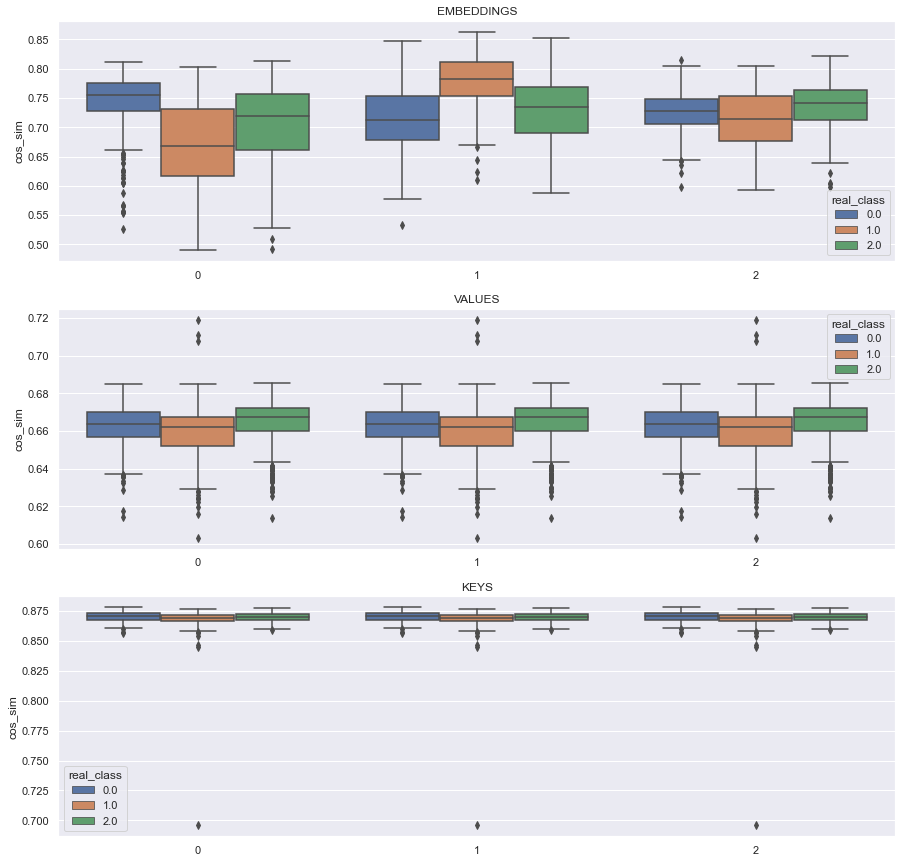

In [3]:
mod = 0
fig, axes = plt.subplots(3,1, figsize=(15, 15))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
axes[0].set(xlabel="")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
axes[1].set(xlabel="")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")
axes[2].set(xlabel="")

plt.savefig(os.path.join(cache_path, "fig","count_directions", f"hatexplain_{mod+1}_layer_model.png"))
;

''

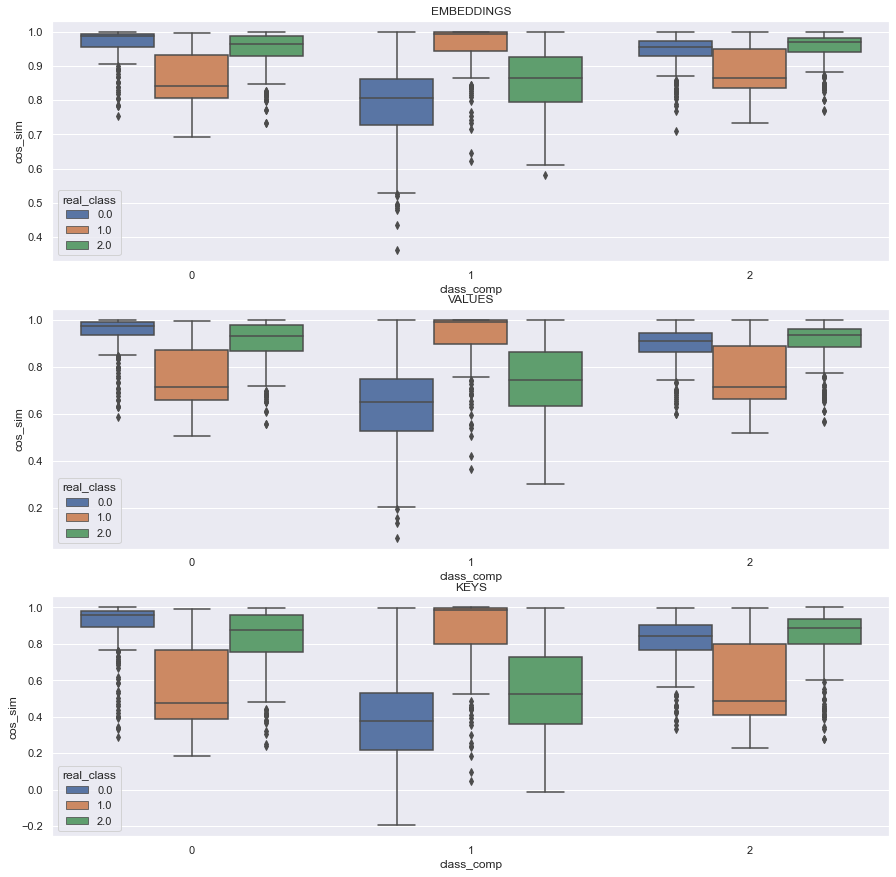

In [4]:
mod = 4
fig, axes = plt.subplots(3,1, figsize=(15, 15))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")
plt.savefig(os.path.join(cache_path, "fig","count_directions", f"hatexplain_{mod+1}_layer_model.png"))
;

On remarque bien que on a notre alignement, classe par classe. On prend simplement le dernier modèle car c'est celui qui possède la convergence la plus forte.

# Yelp-HAT

In [11]:
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=900
                 )

dm = CLSTokenYelpHat50DM(**dm_kwargs)
dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader()

In [18]:
%%capture
cos = torch.nn.CosineSimilarity(dim=1) # cosine to compare with the right token
model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="yelphat",
        num_class=dm.num_class,
        opt="adam"
)

df_array = []

for l in range(5) :

    # update the args for the model
    model_args["num_layers"] = l+1
    ckp = os.path.join(log_path, "PurAttention", f"run=0_yelphat50_l=0{l+1}_h=1_adam", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttention", f"run=0_yelphat50_l=0{l+1}_h=1_adam", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    # the dictionnaries for the dataframes
    key_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    val_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    emb_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    class_id = np.array([])

    with torch.no_grad():

        model = model.to(DEVICE)
        class_rep_res = search_rep(model, dm, mean_calc= l==0) # get the representative of the classes

        pbar = tqdm(enumerate(test_dataloader), total = int(dm.n_data/32))

        for id_batch, batch in pbar:

            ids = batch["token_ids"].to(DEVICE)
            class_id = np.concatenate((class_id, batch["y_true"].to(DEVICE).cpu().numpy()))
            padding_mask = batch["padding_mask"].bool().to(DEVICE)

            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            for c in range(dm.num_class):
                # we'll compute the similarity with the class c
                if l != 0:
                    curr_k = k[l][:, 0, :] # the keys
                    curr_v = v[l][:, 0, :] # the values
                    curr_emb = emb[l+1][:, 0, :] # the embeddings
                else:
                    curr_k = k[l][:, 1:, :].mean(dim=1) # the keys
                    curr_v = v[l][:, 1:, :].mean(dim=1) # the values
                    curr_emb = emb[l+1][:, 1:, :].mean(dim=1)


                # the representative of each class.
                rep_k = class_rep_res[f"class_{c}"]["key"][l]
                rep_v = class_rep_res[f"class_{c}"]["value"][l]
                rep_emb = class_rep_res[f"class_{c}"]["emb"][l+1]


                # compute the cosine similarities
                key_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((key_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_k, curr_k).cpu().numpy()))

                val_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((val_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_v, curr_v).cpu().numpy()))

                emb_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((emb_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_emb, curr_emb).cpu().numpy()))

        temp = (pd.DataFrame(key_cos_values), pd.DataFrame(val_cos_values),
                pd.DataFrame(emb_cos_values), class_id)
        df_array.append(temp)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

''

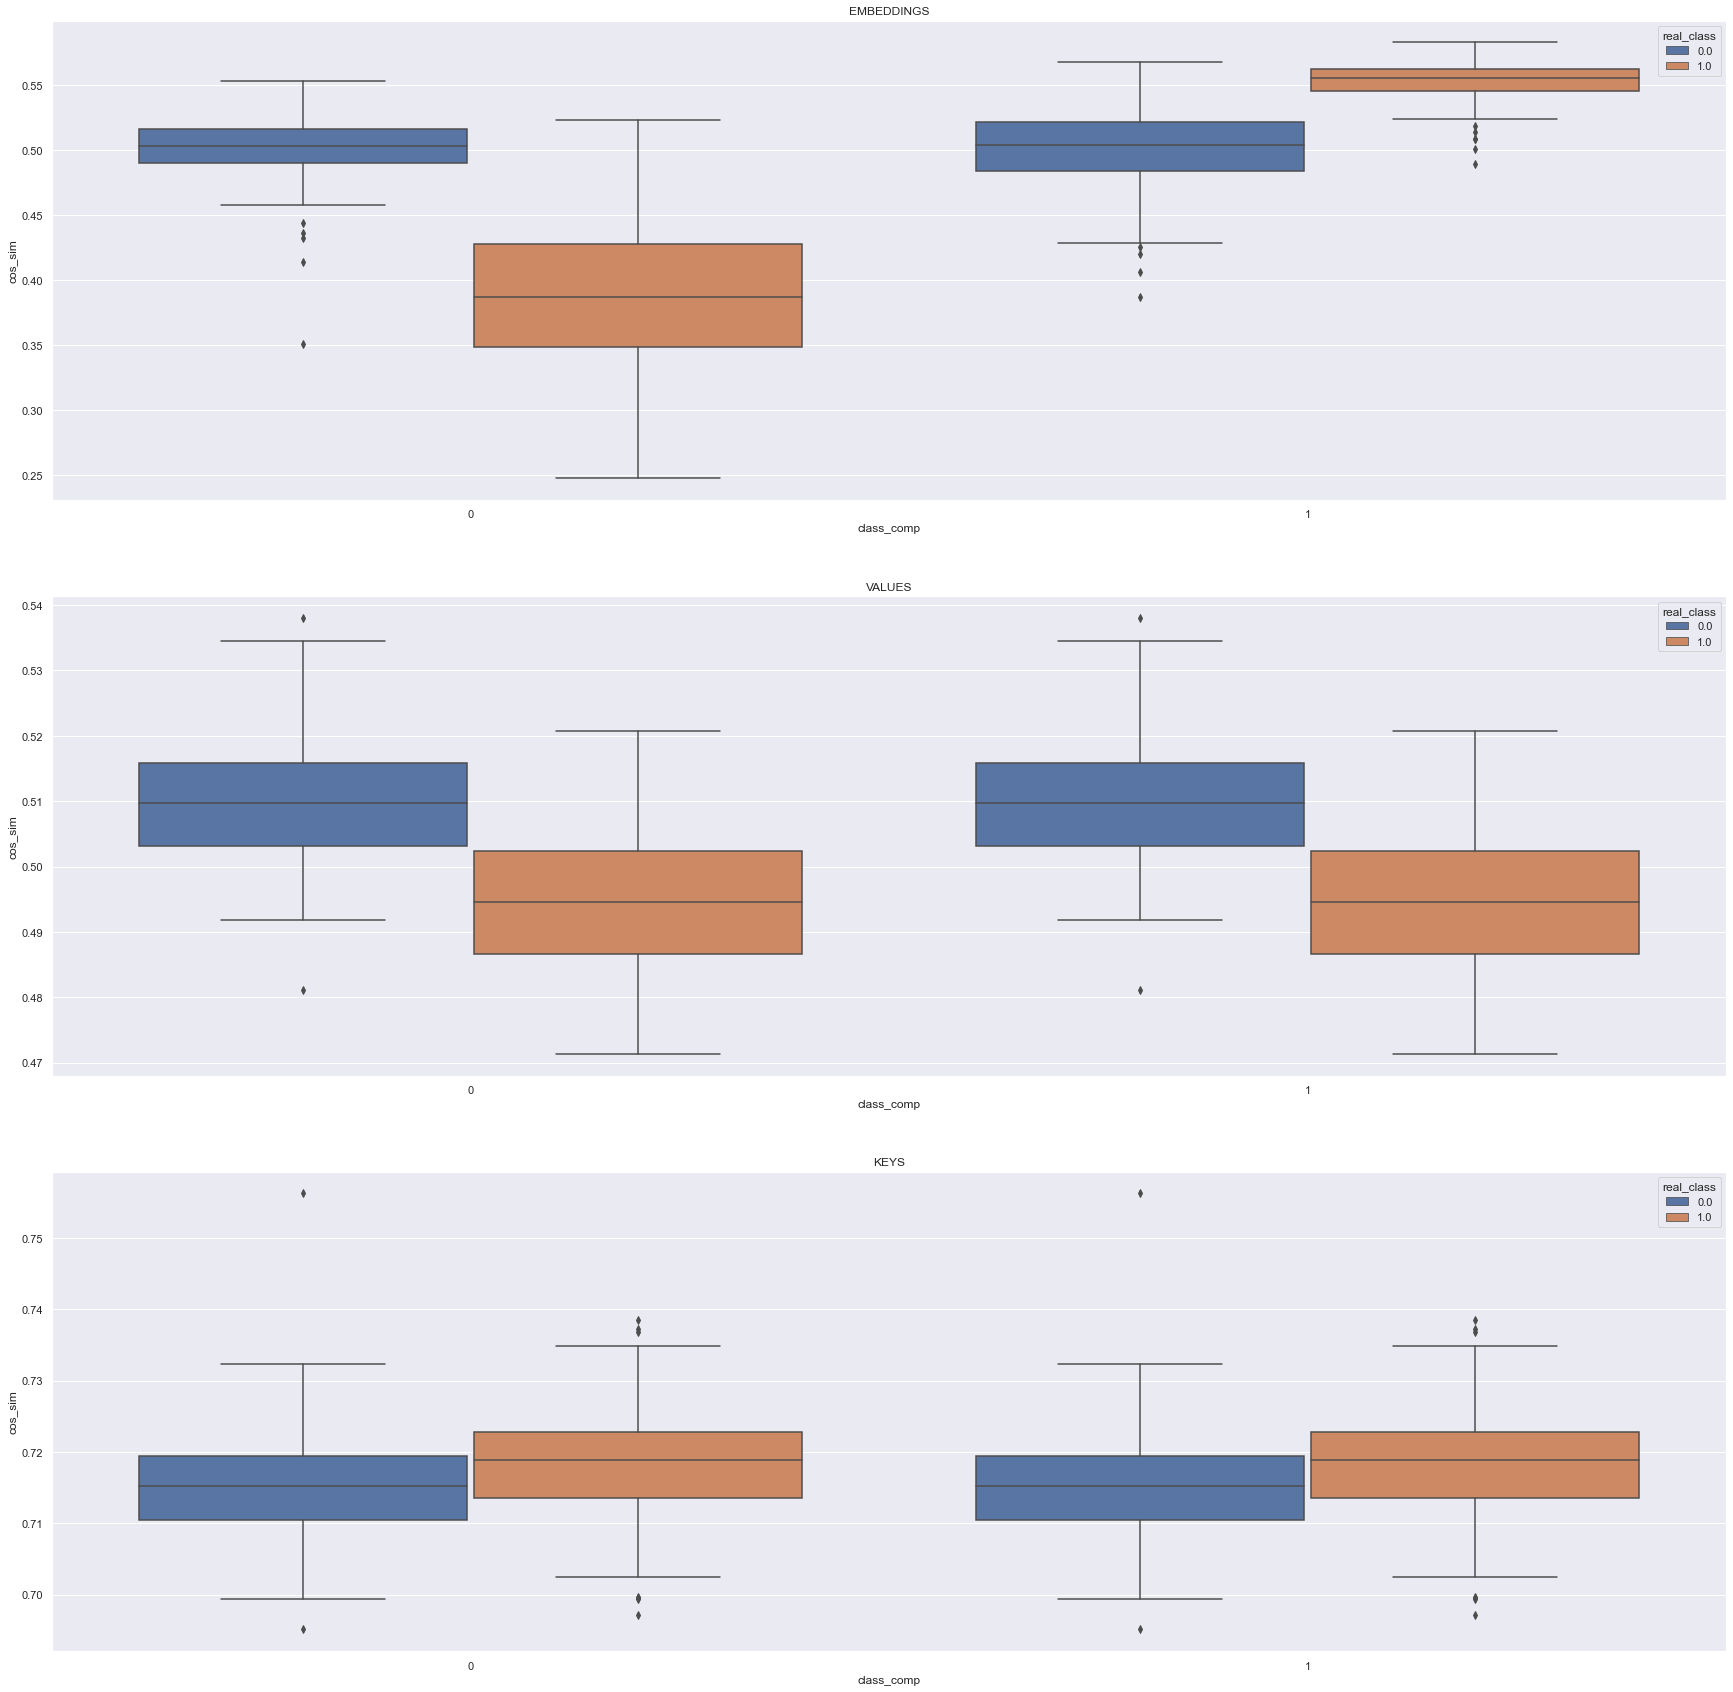

In [14]:
mod = 0
fig, axes = plt.subplots(3,1, figsize=(30, 30))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")

plt.savefig(os.path.join(cache_path, "fig","count_directions", f"yelphat_{mod+1}_layer_model.png"))
;

''

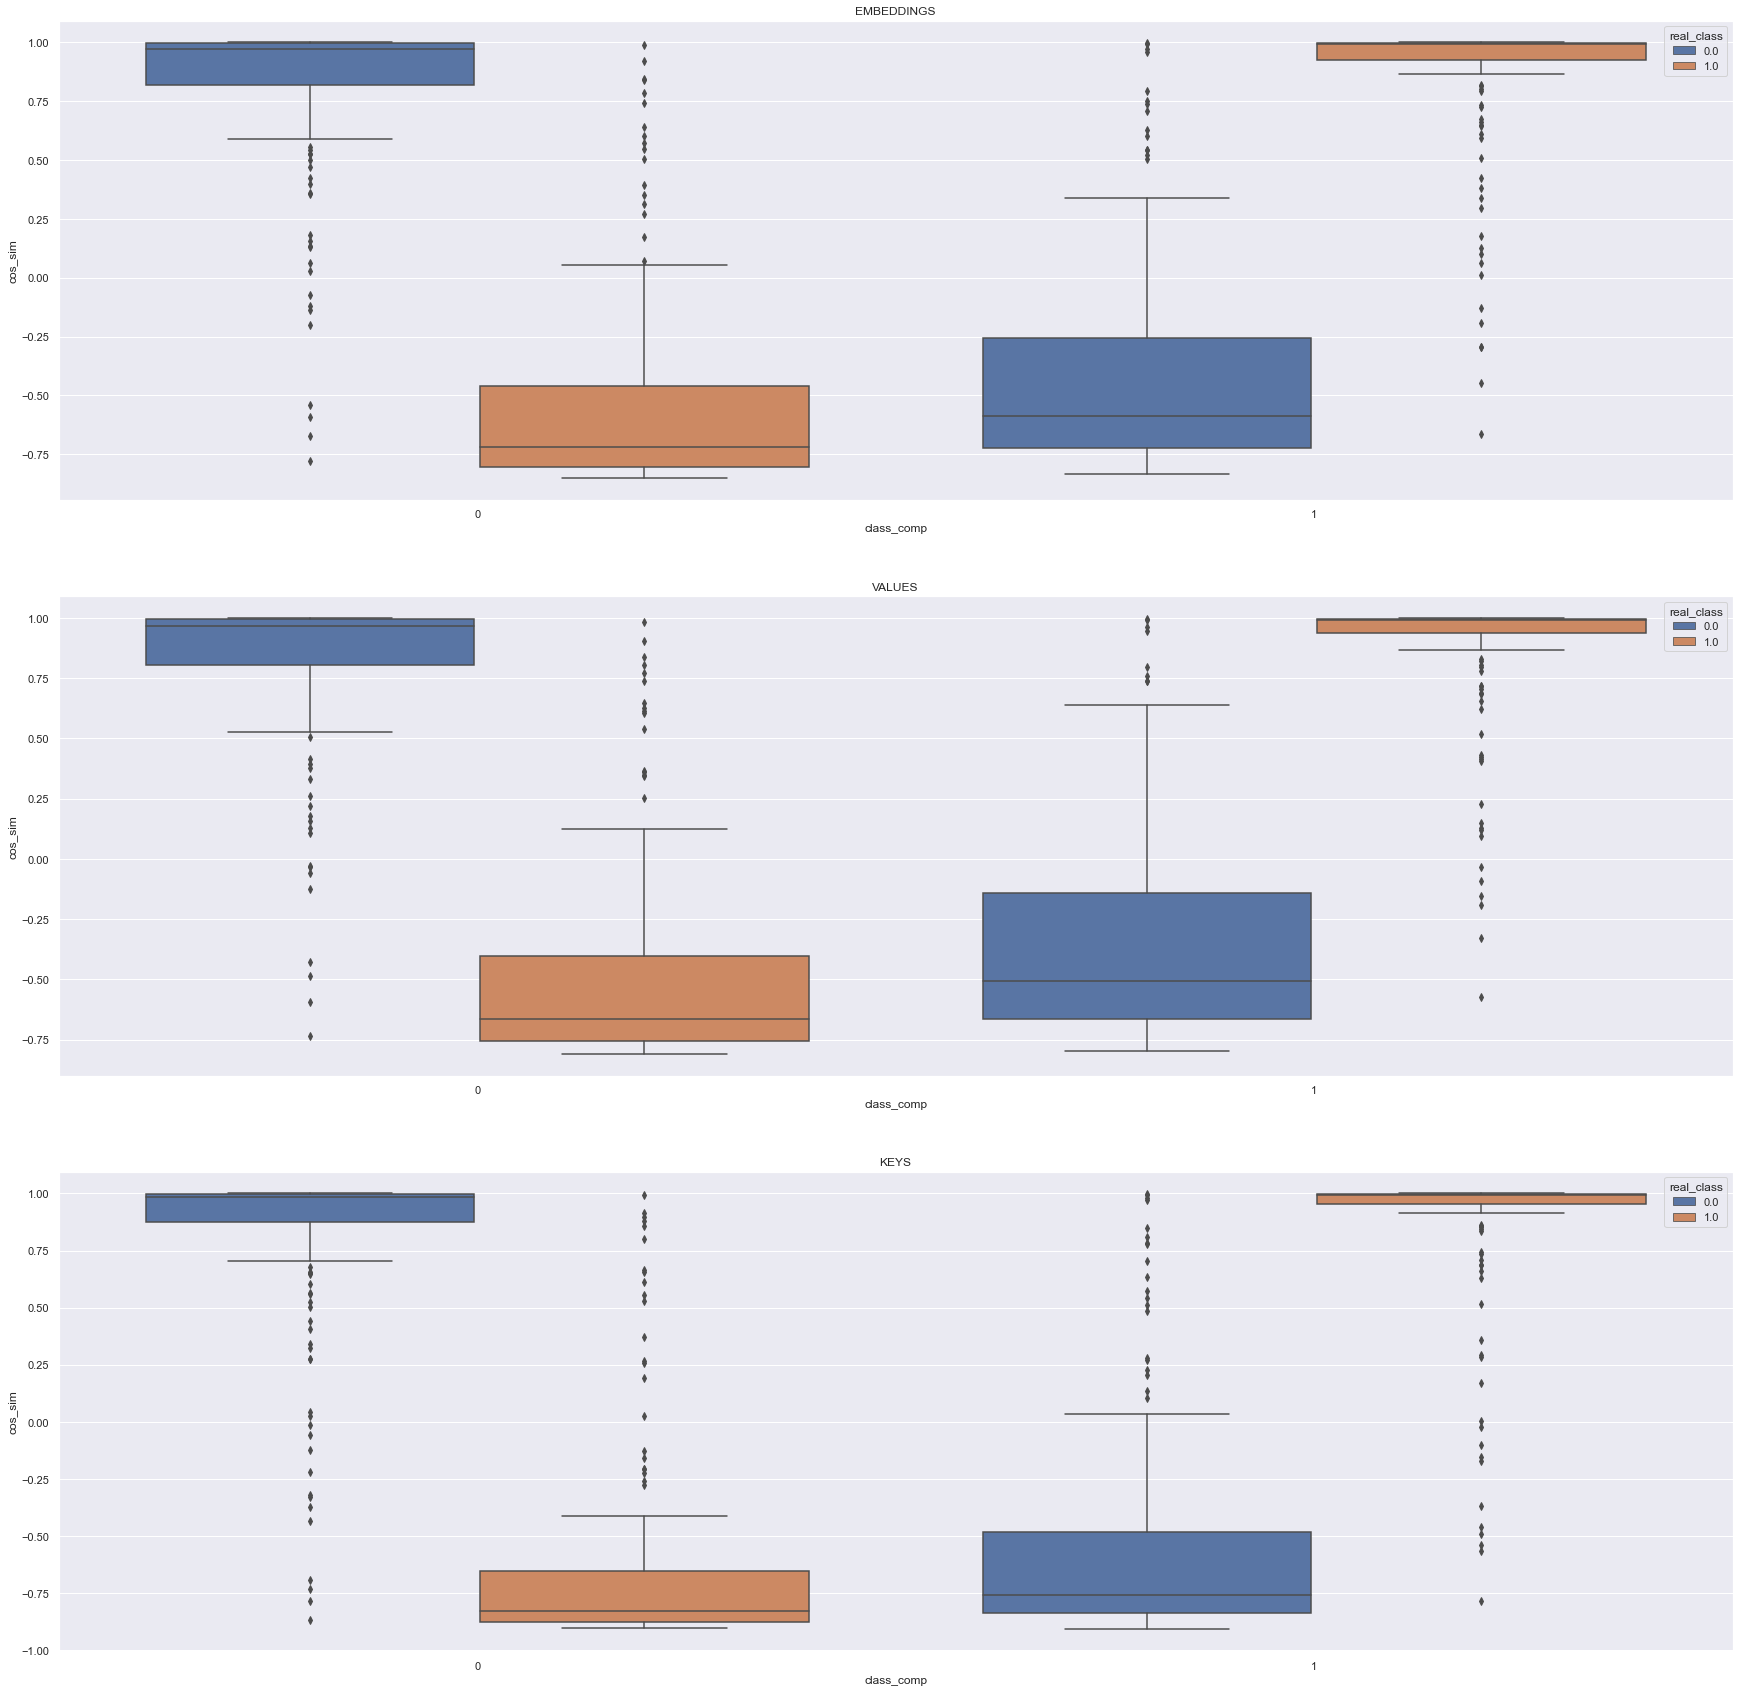

In [9]:
mod = 4
fig, axes = plt.subplots(3,1, figsize=(30, 30))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")

plt.savefig(os.path.join(cache_path, "fig","count_directions", f"yelphat_{mod+1}_layer_model.png"))
;

La séparation des classes est très net sur ce modèle, de plus c'est celui qui fournit la meilleur accuracy. Cet fois ci nous avons bel et bien la mise en évidence d'un lien entre la séparabilité des classes en term de direction et la performance dans la tâche de classification.

# E-SNLI

In [10]:
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=900
                 )

dm = CLSTokenESNLIDM(**dm_kwargs)
dm.prepare_data()
dm.setup(stage="test")
test_dataloader = dm.test_dataloader()

In [11]:
%%capture
cos = torch.nn.CosineSimilarity(dim=1) # cosine to compare with the right token
model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entropy=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="esnli",
        num_class=dm.num_class,
        opt="adam"
)

df_array = []

for l in range(2) :

    # update the args for the model
    model_args["num_layers"] = l+1
    ckp = os.path.join(log_path, "PurAttention", f"run=0_esnli_l=0{l+1}_h=1_adam", "checkpoints", "best.ckpt")
    hparams = os.path.join(log_path, "PurAttention", f"run=0_esnli_l=0{l+1}_h=1_adam", "hparams.yaml")

    # the model
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    # the dictionnaries for the dataframes
    key_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    val_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    emb_cos_values = {
        f"class_{i}_lay_{l+1}": np.array([]) for i in range(dm.num_class)
    }

    class_id = np.array([])

    with torch.no_grad():
        model = model.to(DEVICE)
        class_rep_res = search_rep(model, dm) # get the representative of the classes

        pbar = tqdm(enumerate(test_dataloader), total = int(dm.n_data/32))

        for id_batch, batch in pbar:

            ids = batch["token_ids"].to(DEVICE)
            class_id = np.concatenate((class_id, batch["y_true"].to(DEVICE).cpu().numpy()))
            padding_mask = batch["padding_mask"].bool().to(DEVICE)

            output = model(ids=ids, mask=padding_mask)

            k, v, emb = output["key_embeddings"], output["value_embeddings"], output["hidden_states"]

            for c in range(dm.num_class):

                curr_k = k[l][:, 0, :] # the keys
                curr_v = v[l][:, 0, :] # the values
                curr_emb = emb[l+1][:, 0, :] # the embeddings

                # the representative of each class.
                rep_k = class_rep_res[f"class_{c}"]["key"][l]
                rep_v = class_rep_res[f"class_{c}"]["value"][l]
                rep_emb = class_rep_res[f"class_{c}"]["emb"][l+1]


                # compute the cosine similarities
                key_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((key_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_k, curr_k).cpu().numpy()))

                val_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((val_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_v, curr_v).cpu().numpy()))

                emb_cos_values[f"class_{c}_lay_{l+1}"] = np.concatenate((emb_cos_values[f"class_{c}_lay_{l+1}"],
                                                                 compute_cos(rep_emb, curr_emb).cpu().numpy()))

        temp = (pd.DataFrame.from_dict(key_cos_values), pd.DataFrame.from_dict(val_cos_values),
                pd.DataFrame(emb_cos_values),class_id)
        df_array.append(temp)

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

''

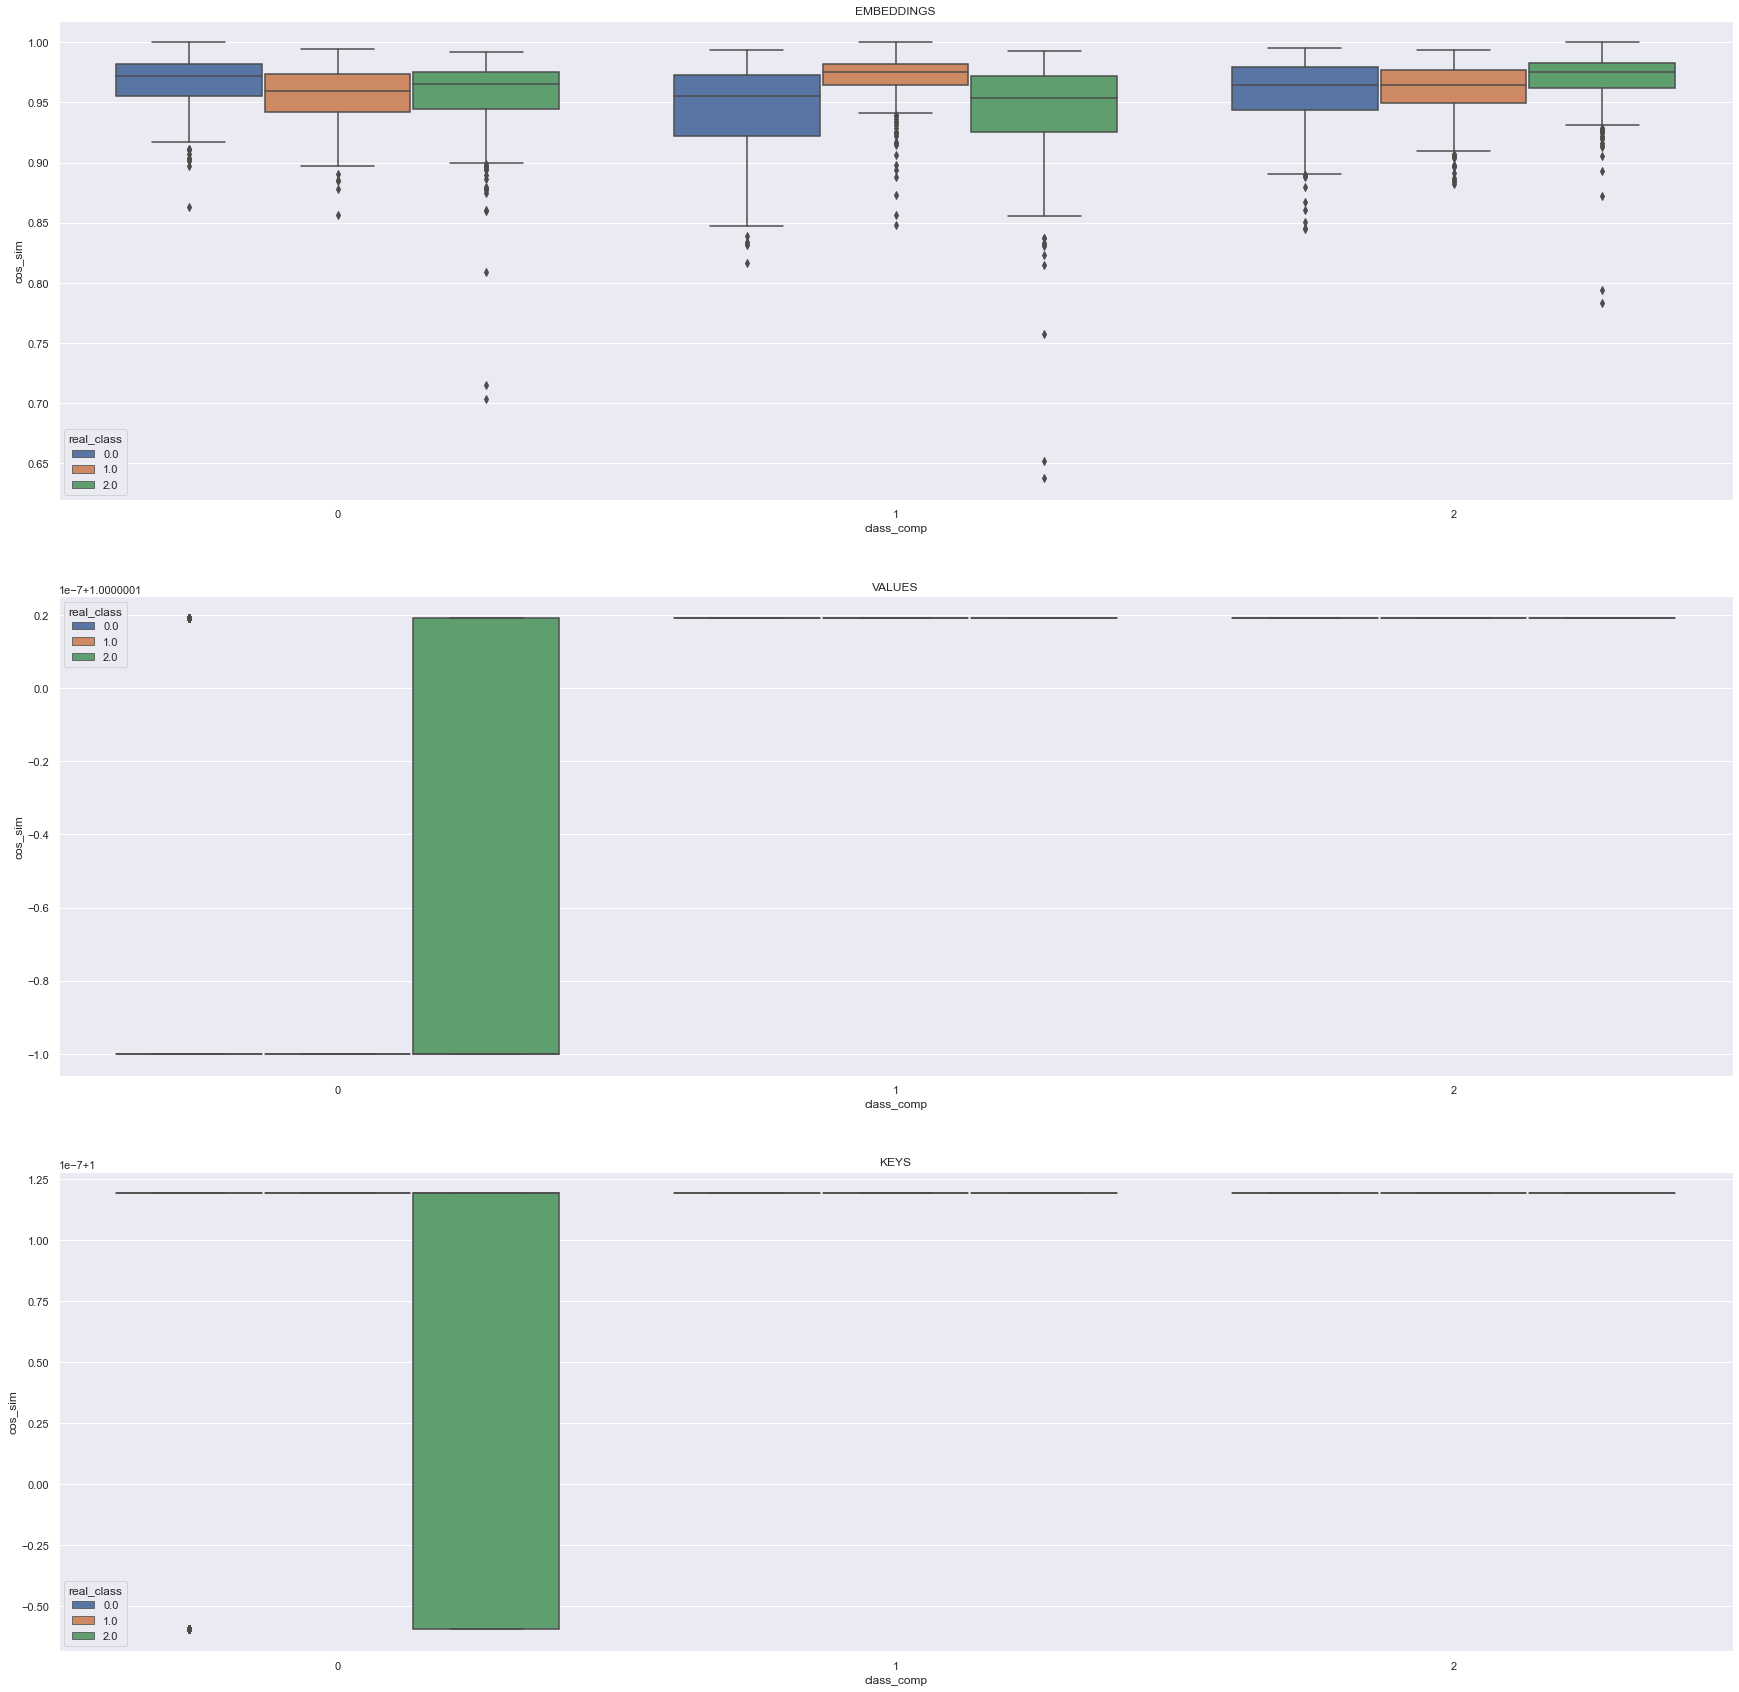

In [12]:
mod = 0
fig, axes = plt.subplots(3,1, figsize=(30, 30))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")

plt.savefig(os.path.join(cache_path, "fig","count_directions", f"esnli_{mod+1}_layer_model.png"))
;

''

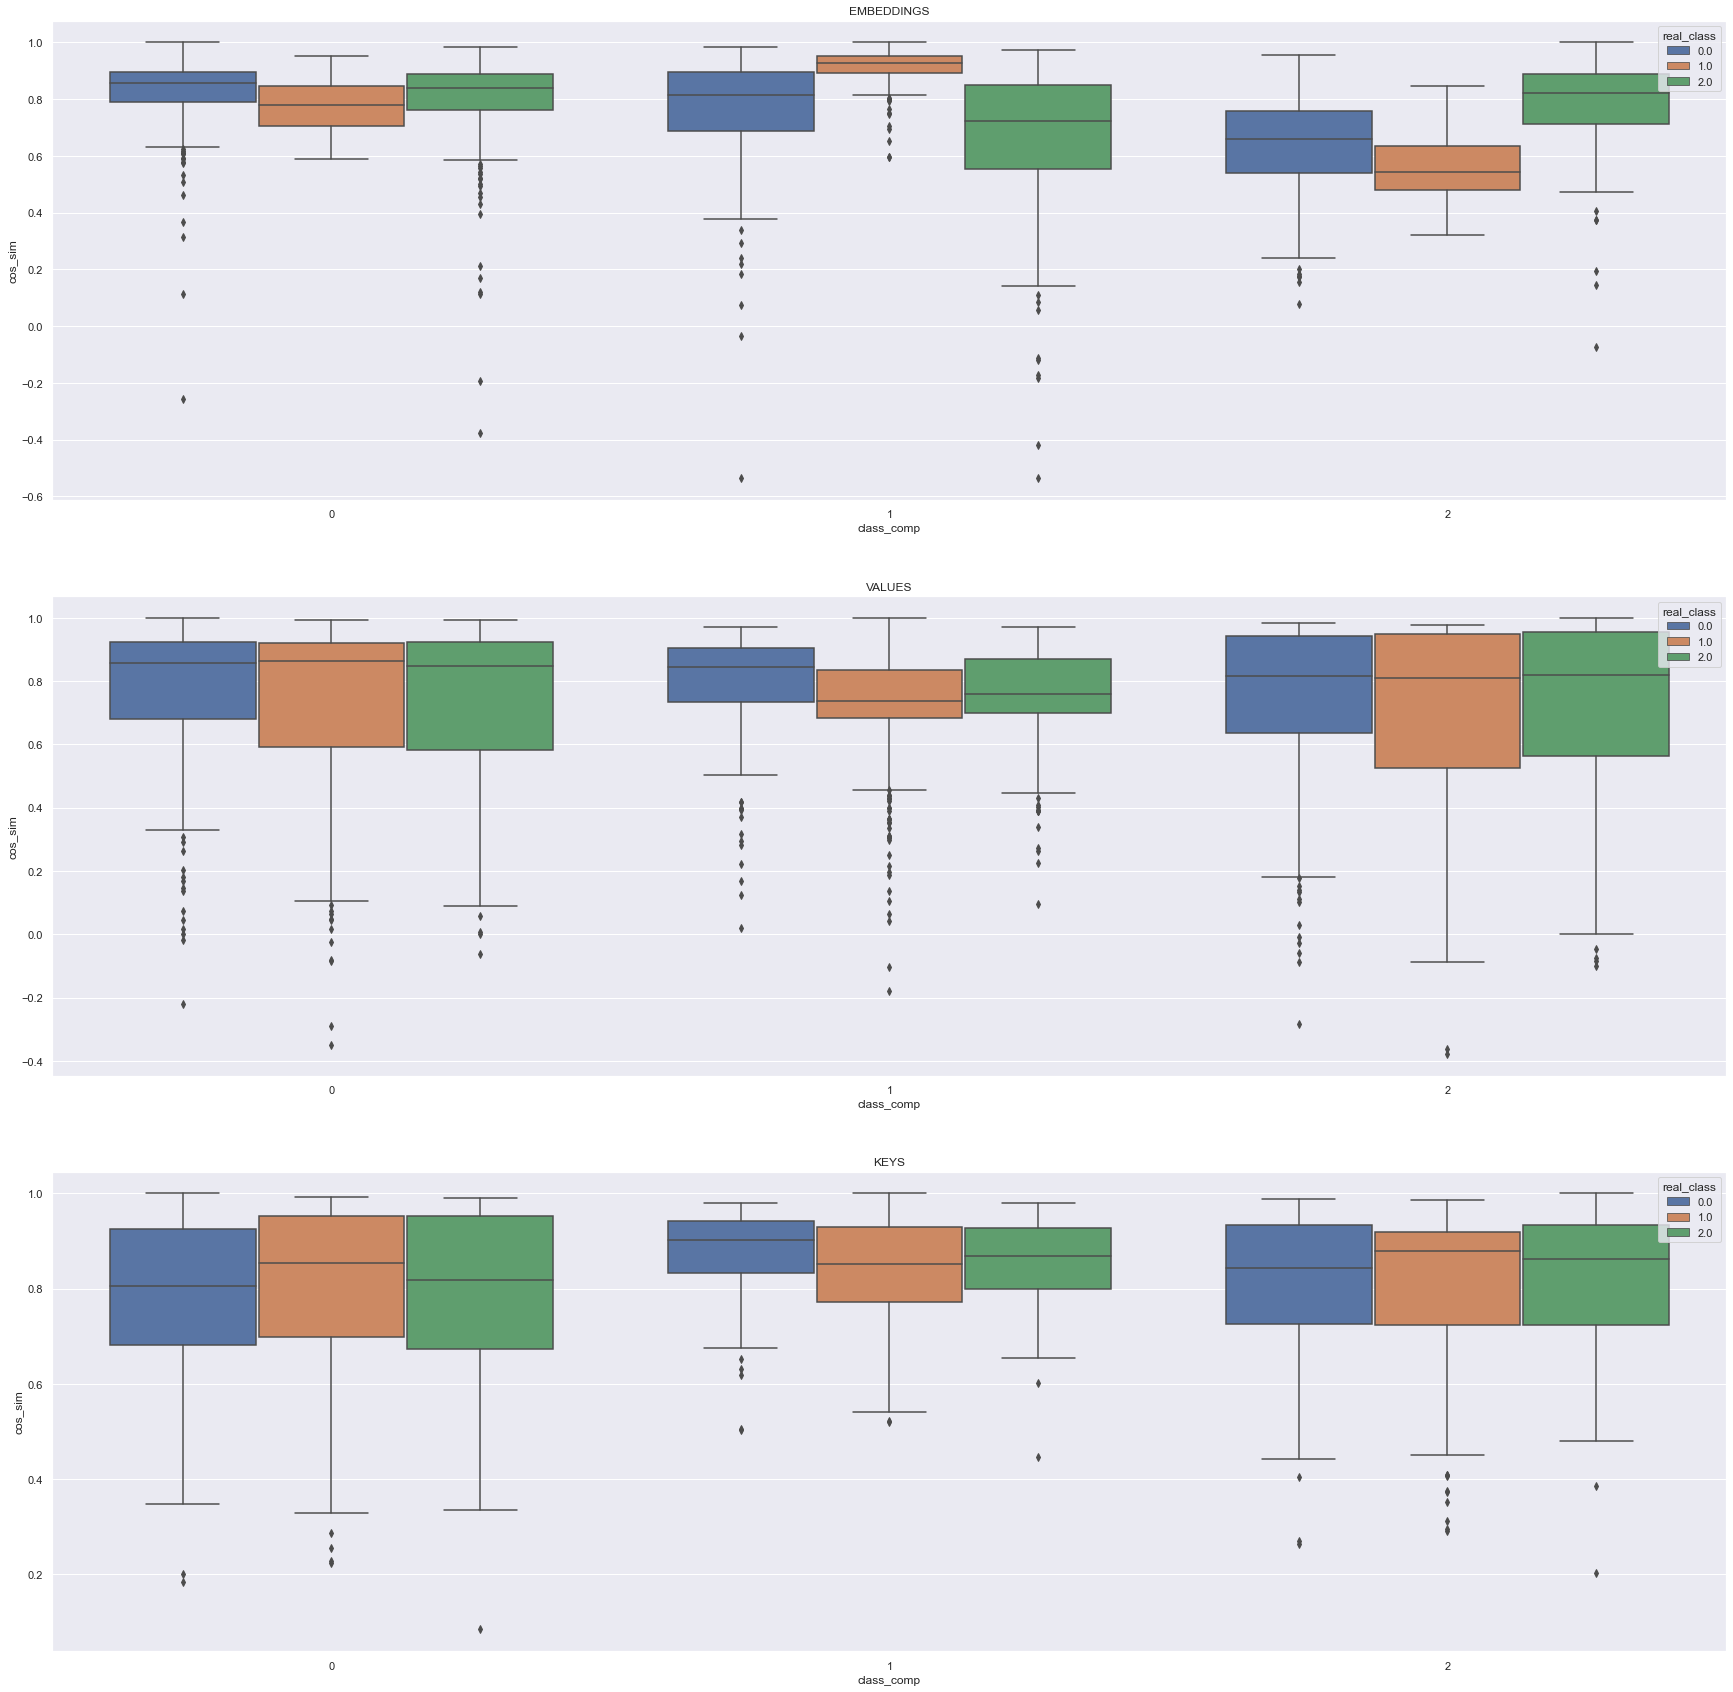

In [13]:
mod = 1
fig, axes = plt.subplots(3,1, figsize=(30, 30))
# the embeddings
df = process_data_frame(df_array[mod][2], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[0])
axes[0].set(title="EMBEDDINGS")
# the values
df = process_data_frame(df_array[mod][1], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[1])
axes[1].set(title="VALUES")
# the keys
df = process_data_frame(df_array[mod][0], df_array[mod][3])
sns.boxplot(data=df, x="class_comp", y="cos_sim", hue="real_class", ax=axes[2])
axes[2].set(title="KEYS")

plt.savefig(os.path.join(cache_path, "fig","count_directions", f"esnli_{mod+1}_layer_model.png"))
;